### Importing Necessary Libraries

In [2]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt


2023-11-13 23:03:23.053819: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Training Data

In [3]:
# Define your image data directory
data_dir = '/Users/macbookpro/Downloads/Group THREE_Corn Leaf'

# Set the image size and batch size
img_size = (224, 224)
batch_size = 32

### Image Preprocessing and Feauture extraction

In [4]:
# Create an ImageDataGenerator to load and preprocess images
data_generator = ImageDataGenerator(rescale=1./255)

# Load images from the directory, organize by classes
data_generator = ImageDataGenerator(rescale=1./255)
data_flow = data_generator.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)



Found 3852 images belonging to 4 classes.


In [5]:

# Path to the downloaded VGG16 weights file
weights_path = '/Users/macbookpro/Downloads/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Load the VGG16 model with local weights
base_model = VGG16(weights=weights_path, include_top=False)


In [6]:

# Customize the model by adding a Global Average Pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=x)

### Extract features from the dataset


In [7]:
X = []
y = []

for _ in range(len(data_flow)):
    batch_data, batch_labels = data_flow.next()
    features = model.predict(batch_data)
    X.extend(features)
    y.extend(np.argmax(batch_labels, axis=1))

X = np.array(X)
y = np.array(y)


1/1 [==============================] - 2s 2s/step


### Split the dataset into training and testing sets


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


### Training and Testing the model

In [9]:
# Create an SVM classifier
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)

# Train the SVM classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_classifier.predict(X_test)

### Accuracy

In [10]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9455017301038062


### ROC-AUC score

In [11]:
# Calculate the ROC-AUC score
y_prob = svm_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
print("Area under ROC Curve (AUC):", roc_auc)

Area under ROC Curve (AUC): 0.992296545428151


### Confusion Matrix

Confusion Matrix:
 [[122   0  30   1]
 [  1 370   1   0]
 [ 27   0 265   1]
 [  2   0   0 336]]


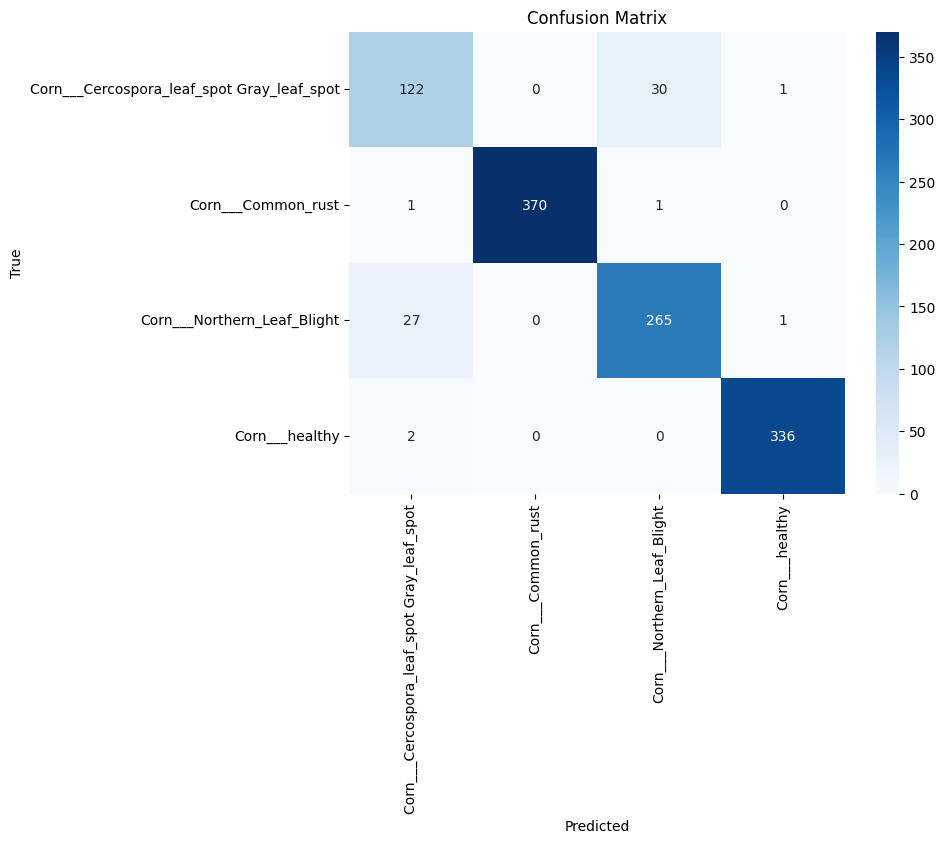

In [15]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix as a heatmap
import seaborn as sns

class_labels = list(data_flow.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


### ROC curves for each class


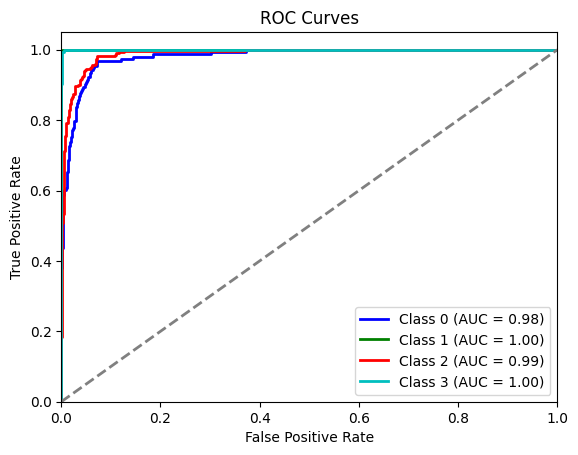

In [13]:
n_classes = len(np.unique(y_test))
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
colors = ['b', 'g', 'r', 'c'] 
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label=f'Class {i} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

### Calculate precision, recall, F1 score, and support

In [14]:
from sklearn.metrics import precision_recall_fscore_support
from prettytable import PrettyTable

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

# Create a PrettyTable for tabulating the results
results_table = PrettyTable()
results_table.field_names = ["Metric", "Value"]
results_table.add_row(["Accuracy", accuracy])
results_table.add_row(["Precision", precision])
results_table.add_row(["Recall", recall])
results_table.add_row(["F1 Score", f1_score])

print(results_table)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.9455017301038062 |
| Precision | 0.9456027861316061 |
|   Recall  | 0.9455017301038062 |
|  F1 Score | 0.9455428713245162 |
+-----------+--------------------+
